# Telecom Customer Churn Prediction & Analysis

**Goal:** Build a machine learning model to predict which customers are likely to churn so the company can intervene with targeted retention efforts (discounts, service improvements).

**Dataset:** The data is loaded from `bigml_59c28831336c6604c800002a.csv`.

## Stakeholder Insight

Churn is costly for the business. The raw data is imbalanced (~85% non-churn, ~15% churn). Standard Accuracy is a poor metric in this case. We must rely on metrics that handle imbalance well, such as **Precision, Recall, and F1-score**, to ensure we effectively identify actual churn risks without overwhelming marketing teams with false positives.


In [343]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Set visualization style
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

## Data Loading and Initial Exploration

We load the dataset and perform initial inspections of the structure, statistics, and target variable distribution.

In [344]:
# Load dataset
file_path = 'C:\\Users\\user\\Documents\\phase3\\project\\bigml_59c28831336c6604c800002a.csv'
df = pd.read_csv(file_path)

print("DataFrame Info:")
df.info()
print("\nDescriptive Statistics:")
df.describe()
print("\nFirst 5 Rows:")
df.head()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Target Variable Distribution<br>
We analyze the churn column to understand class balance.<br>


In [345]:
# Analyze class distribution
print("Churn Value Counts (Normalized):")
print(df['churn'].value_counts(normalize=True))


Churn Value Counts (Normalized):
churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


The dataset is highly imbalanced. Most customers (around 85%) did not churn. This confirms our need to use metrics like Recall, Precision, and F1-score.

## Data Preparation and Feature Engineering
We drop redundant columns. We also check unique values in categorical features before encoding.

In [346]:
# Check unique values in categorical features
print("Unique values in categorical features:")
print(df[['state', 'international plan', 'voice mail plan']].nunique())

# Drop redundant and unnecessary columns
df_reduced = df.drop(columns=[
    'phone number',
    'total day charge',
    'total eve charge',
    'total night charge',
    'total intl charge'
])


Unique values in categorical features:
state                 51
international plan     2
voice mail plan        2
dtype: int64


## Visualizing Key Relationships (EDA)
We visualize how key features relate to the target variable churn to gain business insights.<br>


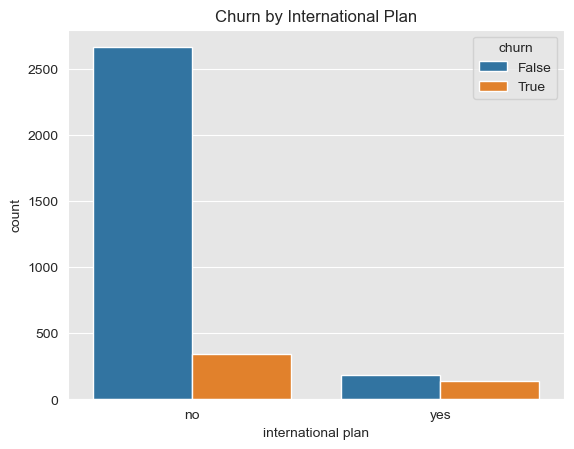

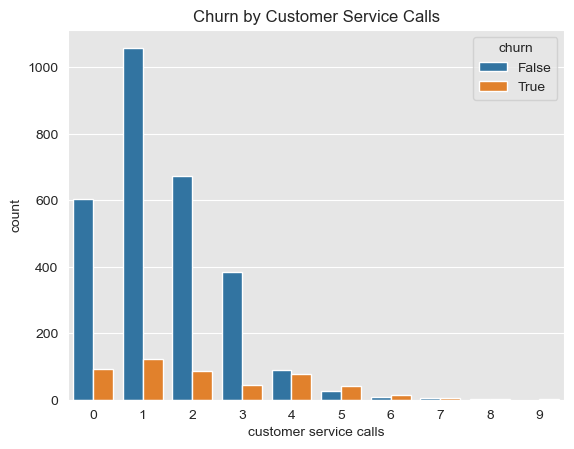

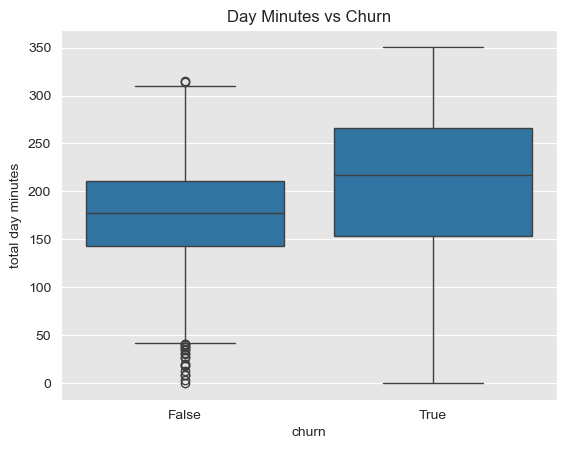

In [347]:
# Churn vs International Plan
sns.countplot(x='international plan', hue='churn', data=df_reduced)
plt.title('Churn by International Plan')
plt.show()

# Churn vs Customer Service Calls
sns.countplot(x='customer service calls', hue='churn', data=df_reduced)
plt.title('Churn by Customer Service Calls')
plt.show()

# Distribution of Day Minutes by Churn
sns.boxplot(x='churn', y='total day minutes', data=df_reduced)
plt.title('Day Minutes vs Churn')
plt.show()


### Business Insights<br>
1. International Plan: Customers with international plans have a disproportionately higher churn rate. This is a strong predictor.<br>
2. Customer Service Calls: Churn rate spikes dramatically after 3 or 4 service calls, indicating unresolved issues are a major driver of dissatisfaction.<br>
3. Total Day Minutes: Heavy daytime users are more likely to churn, possibly due to high bills.

## Data Preprocessing: Encoding and Scaling
We convert categorical string variables into numerical formats suitable for scikit-learn models. We also split the data into train and test sets before scaling to prevent data leakage.

In [348]:
# Binary encoding True/False and yes/no
df_reduced['international plan'] = df_reduced['international plan'].map({'yes': 1, 'no': 0})
df_reduced['voice mail plan'] = df_reduced['voice mail plan'].map({'yes': 1, 'no': 0})
df_reduced['churn'] = df_reduced['churn'].map({True: 1, False: 0})

# One-hot encode area code and drop 'state' (too many unique values)
df_reduced = pd.get_dummies(df_reduced, columns=['area code'], drop_first=True, dtype=int)
df_reduced = df_reduced.drop(columns=['state'])
df_reduced.head()


,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn,area code_415,area code_510
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,1,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,0,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,1,0


## Model Training and Evaluation
We separate data into features (X) and target (y), and then into training and testing sets.

In [349]:
# Train/Test Split
X = df_reduced.drop('churn', axis=1)    
y = df_reduced['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2666, 15), Test shape: (667, 15)


We use StandardScaler to normalize the range of numerical features so they are on the same scale for modeling.

In [350]:
# Select numerical columns to scale
numerical_cols = [
    'account length', 'number vmail messages', 'total day minutes',
    'total day calls', 'total eve minutes',
    'total eve calls', 'total night minutes',
    'total night calls', 'total intl minutes',
    'total intl calls', 'customer service calls'
]
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) 


## Model 1: Logistic Regression (Baseline)
We start with a simple, interpretable logistic regression model. We use class_weight='balanced' to handle the data imbalance internally within the model fitting process.

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       570
           1       0.35      0.74      0.48        97

    accuracy                           0.76       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.76      0.79       667

Confusion Matrix:
[[436 134]
 [ 25  72]]


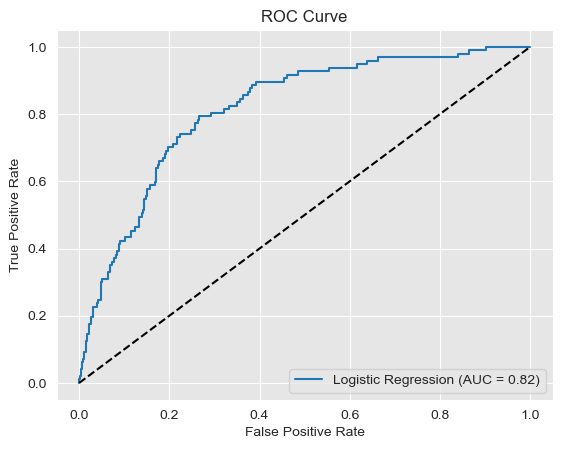

In [351]:
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# ROC Curve
y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show();



## Model 2: Decision Tree Classifier

Following the logistic regression baseline, we introduce a nonparametric model: the Decision Tree Classifier. We first run an untuned version to establish a baseline for this model type.

Untuned Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       570
           1       0.63      0.65      0.64        97

    accuracy                           0.89       667
   macro avg       0.79      0.79      0.79       667
weighted avg       0.89      0.89      0.89       667

Confusion Matrix:
[[533  37]
 [ 34  63]]


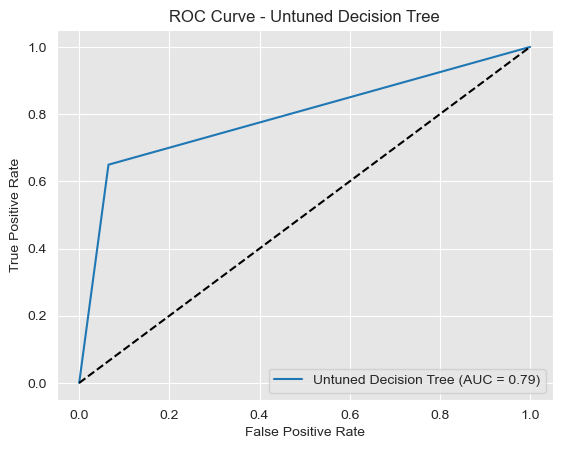

In [ ]:
# Initial Decision Tree
treemodel1 = DecisionTreeClassifier(random_state=42, class_weight='balanced')
treemodel1.fit(X_train, y_train)

# Predictions
y_pred_mod1 = treemodel1.predict(X_test)
# Evaluation
print("Untuned Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_mod1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mod1))
# ROC Curve for Untuned DT
y_prob_mod1 = treemodel1.predict_proba(X_test)[:, 1]
fpr_mod1, tpr_mod1, thresholds_dt = roc_curve(y_test, y_prob_mod1)
roc_auc_mod1 = auc(fpr_mod1, tpr_mod1)
plt.figure()
plt.plot(fpr_mod1, tpr_mod1, label=f'Untuned Decision Tree (AUC = {roc_auc_mod1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Untuned Decision Tree')
plt.legend(loc='lower right')
plt.show();




The untuned model shows a recall of 65%, precision of 63% and an f1-score of 64%. This is a moderate model which we can improve upon.

## Model 3: Tuned Decision Tree


For better generalization and a balance between precision and recall. We focus on max_depth, min_samples_split, and min_samples_leaf to regularize the model.

Tuned Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       570
           1       0.68      0.75      0.71        97

    accuracy                           0.91       667
   macro avg       0.82      0.85      0.83       667
weighted avg       0.92      0.91      0.91       667

Confusion Matrix:
[[535  35]
 [ 24  73]]


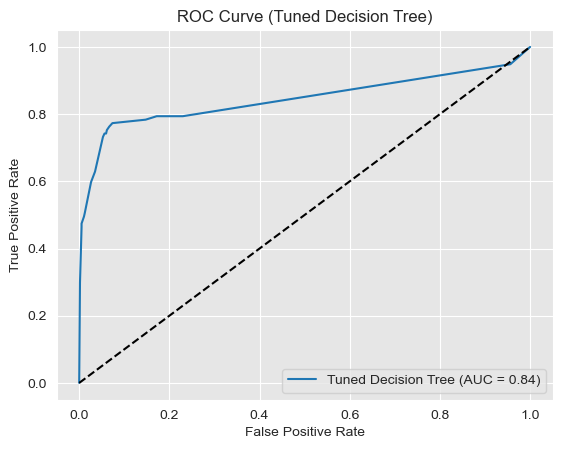

In [353]:
# Manually Tuned Decision Tree
treemodel2 = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=5,              
    min_samples_split=20,     
    min_samples_leaf=10       
)
treemodel2.fit(X_train, y_train)

# Predictions
y_pred_mod2 = treemodel2.predict(X_test)

# Evaluation
print("Tuned Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_mod2))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mod2))

# ROC Curve for Tuned DT
y_prob_mod2 = treemodel2.predict_proba(X_test)[:, 1]
fpr_mod2, tpr_mod2, thresholds_dt = roc_curve(y_test, y_prob_mod2)
roc_auc_mod2 = auc(fpr_mod2, tpr_mod2)
plt.figure()
plt.plot(fpr_mod2, tpr_mod2, label=f'Tuned Decision Tree (AUC = {roc_auc_mod2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned Decision Tree)')
plt.legend(loc='lower right')
plt.show();


The untuned model shows a recall of 75%, precision of 68% and an f1-score of 71%. This is the final improved decision tree model.

The Tuned Decision Tree provides the best balance of identifying potential churn risks 0.75 for recall while maintaining high Precision 0.68 compared to the other models. This precision score is vital for the business stakeholder: for every 10 people flagged by the model, almost 7 are actual churners, making the targeted retention efforts viable and cost-effective. We select this as our final model for deployment.

## Limitations and Recommendations
### Limitations
Data Scope: This model is built solely on historical data provided in this snapshot. Market changes or new competitor offers might change churn behavior in ways the model can't predict.<br>

Performance Trade-off: The model still misses about 25% of actual churners (False Negatives). The precision also means about a third of customers flagged for a costly intervention would not have churned anyway (False Positives).<br>

### Recommendations

Based on our insights and the final decision tree model, we provide the following actionable recommendations:<br>

Proactive International Plan Offers: The 'international plan' feature was a key predictor of churn. The business should proactively reach out to customers without the plan who use high volumes of day minutes and offer a discounted international rate.<br>

Improve Customer Support Triage: Customers with 4 or more customer service calls have a significantly higher churn rate. The company should investigate systemic issues causing repeat calls and implement a priority support channel for these frustrated customers.<br>

Targeted Retention Campaigns: The selected model can flag actual churners with a F1-score around 0.71. Use this model weekly to generate a list of high-risk customers for targeted discount offers or service check-in calls.